<a href="https://colab.research.google.com/github/emumily/fetch-assignment/blob/br1/Fetch_Assignment_EmilyTang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise:
## First: explore the data
Review the unstructured csv files and answer the following questions with code that supports your conclusions:

**Are there any data quality issues present?** \
- Missing data in all tables. Transaction table had different types of missing data, such as empty cell and Nan, so those had to be accounted for. \

**Are there any fields that are challenging to understand?**
- Bit confusing why FINAL_QUANTITY in Transactions could be 0, but the cost was greater than $0.

We recommend using SQL or python and data visualization to examine the data.

# Second: **provide SQL queries**
Answer three of the following questions with at least one question coming from the closed-ended and one from the open-ended question set. *Each question should be answered using one query.*

#### Closed-ended questions:
**What are the top 5 brands by receipts scanned among users 21 and over?** \
- note: some missing Birthday - Can show with and without missing? \

**What are the top 5 brands by sales among users that have had their account for at least six months?**\
**What is the percentage of sales in the Health & Wellness category by generation?**
#### Open-ended questions: make assumptions and clearly state them.
**Who are Fetch’s power users?\
Which is the leading brand in the Dips & Salsa category?\
At what percent has Fetch grown year over year?**

# Third: communicate with stakeholders
**Construct an email or slack message that is understandable to a product or business leader who is not familiar with your day-to-day work. Summarize the results of your investigation.** \
Include:
1. Key data quality issues and outstanding questions about the data \

2. One interesting trend in the data \
3. Use a finding from part 2 or come up with a new insight \
4.
Request for action: explain what additional help, info, etc. you need to make sense of the data and resolve any outstanding issues

In [2]:
# since I'm using Google Colab, I need to upload the CSV files to Colab (NOT on Github)
# This function pulls up the Finder for me to select the CSV files, and then uploads them to the "uploaded" object.
from google.colab import files
uploaded = files.upload()

Saving PRODUCTS_TAKEHOME.csv to PRODUCTS_TAKEHOME.csv
Saving TRANSACTION_TAKEHOME.csv to TRANSACTION_TAKEHOME.csv
Saving USER_TAKEHOME.csv to USER_TAKEHOME.csv


In [3]:
# Library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install pandasql
from pandasql import sqldf
import io

# Import products, transactions, and users data files (csv)
products = pd.read_csv(io.BytesIO(uploaded['PRODUCTS_TAKEHOME.csv']))
transactions = pd.read_csv(io.BytesIO(uploaded['TRANSACTION_TAKEHOME.csv']))
users = pd.read_csv(io.BytesIO(uploaded['USER_TAKEHOME.csv']))

In [88]:
# How many rows x columns for each dataset?
products.shape , transactions.shape, users.shape

((845552, 7), (50000, 8), (100000, 6))

#### Products Table Exploration

`BARCODE` is the only numeric value (which we should treat as a string)
Lots of NaN (missing values)

In [4]:
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [5]:
# Missing values NaN, empty cells, possibly null - account for these by making them all NaN
products = products.replace(r'^\s*$', np.nan, regex=True)

In [6]:
# With each breakdown of the category, there are more missing values, which makes sense as products might not fit into specific subcategories.
# Manufacturer and Brand are quite high in missing percentage, around ~27%.
missing_counts = products.isna().sum()
missing_percent = 100 * (missing_counts / len(products))

missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})
print(missing_summary)

              Missing Count  Missing %
CATEGORY_1              111   0.013128
CATEGORY_2             1424   0.168411
CATEGORY_3            60566   7.162895
CATEGORY_4           778093  92.021898
MANUFACTURER         226474  26.784160
BRAND                226472  26.783923
BARCODE                4025   0.476020


In [7]:
unique_counts = products.nunique()
print(unique_counts)

CATEGORY_1          27
CATEGORY_2         121
CATEGORY_3         344
CATEGORY_4         127
MANUFACTURER      4354
BRAND             8122
BARCODE         841342
dtype: int64


In [86]:
print(products['BRAND'].value_counts())
# there are also brands labeled "BRAND NOT KNOWN"

BRAND
REM BRAND          20813
BRAND NOT KNOWN    17025
PRIVATE LABEL      13467
CVS                 6400
SEGO                4831
                   ...  
ALAGA                  1
A PINATA 4 U           1
SQWINCHER              1
MOSISO                 1
GATEWAY                1
Name: count, Length: 8122, dtype: int64


In [48]:
# convert BARCODE to string. I noticed that just astype(str) will keep the .0 from the float.
products['BARCODE'] = products['BARCODE'].astype(str).str.rstrip('.0')

In [49]:
products.head()

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,79649440782
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,23278011028
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,461817824225
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,35000466815
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,806810850459


#### Transactions Table Exploration
`FINAL_SALE` has empty cells, `BARCODE` has 25% NaNs.

In [9]:
transactions.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [10]:
# Transactions has some blank, some not of consistent type
# (eg "zero", a string and 1.00, a float)
# having difficulty understanding why FINAL_QUANTITY could be zero, but FINAL_SALE is >0
transactions['FINAL_QUANTITY'].dtype # object

dtype('O')

In [11]:
transactions['FINAL_QUANTITY'].value_counts()

,count
FINAL_QUANTITY,
1.00,35698
zero,12500
2.00,1285
3.00,184
4.00,139
...,...
6.22,1
1.22,1
1.23,1


In [33]:
# change SCAN_DATE to be Date format
transactions['SCAN_DATE'] = pd.to_datetime(transactions['SCAN_DATE']).dt.normalize() #or dt.date

In [54]:
# Missing values NaN, empty cells, possibly null - account for these by making them all NaN
# transactions.replace({"": np.nan, "NULL": np.nan, "NA": np.nan}, inplace=True) originally did this, but it wasn't affecting the object (FINAL_SALE)
transactions = transactions.replace(r'^\s*$', np.nan, regex=True)

In [55]:
missing_counts = transactions.isna().sum()
missing_percent = 100 * (missing_counts / len(transactions))

missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})
print(missing_summary)

                Missing Count  Missing %
RECEIPT_ID                  0        0.0
PURCHASE_DATE               0        0.0
SCAN_DATE                   0        0.0
STORE_NAME                  0        0.0
USER_ID                     0        0.0
BARCODE                     0        0.0
FINAL_QUANTITY              0        0.0
FINAL_SALE              12500       25.0


In [15]:
# I also want to convert "zero" to 0.0 in the "FINAL_QUANTITY" variable
transactions['FINAL_QUANTITY'] = transactions['FINAL_QUANTITY'].replace('zero', 0.0).astype(float)

In [52]:
unique_counts = transactions.nunique()
print(unique_counts)

RECEIPT_ID        24440
PURCHASE_DATE        89
SCAN_DATE            89
STORE_NAME          954
USER_ID           17694
BARCODE           11026
FINAL_QUANTITY       87
FINAL_SALE         1434
dtype: int64


In [50]:
# convert BARCODE to string, stripping the .0 at the end
transactions['BARCODE'] = transactions['BARCODE'].astype(str).str.rstrip('.0')

In [51]:
# double checking - looks good for now?
transactions.head()

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.0,NaN
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20,ALDI,62c08877baa38d1a1f6c211a,nan,0.0,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,78742229751,1.0,NaN
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,0.0,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.0,NaN


In [108]:
transactions['PURCHASE_DATE'].min(), transactions['PURCHASE_DATE'].max()

('2024-06-12', '2024-09-08')

In [19]:
users.head()

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female


In [20]:
users = users.replace(r'^\s*$', np.nan, regex=True)

In [21]:
missing_counts = users.isna().sum()
missing_percent = 100 * (missing_counts / len(users))

missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})
print(missing_summary)

              Missing Count  Missing %
ID                        0      0.000
CREATED_DATE              0      0.000
BIRTH_DATE             3675      3.675
STATE                  4812      4.812
LANGUAGE              30508     30.508
GENDER                 5892      5.892


In [41]:
# changing dates (currently Object) to type Date (and get rid of time)
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE']).dt.normalize()
users['BIRTH_DATE'] = pd.to_datetime(users['BIRTH_DATE']).dt.normalize()

In [44]:
# Assumption: Age is calculated based on present date, February 19, 2025.
reference_date = pd.to_datetime("2025-02-19")  # Fixed date
users['AGE'] = (reference_date - users['BIRTH_DATE']).dt.days // 365  # Convert day to years
users[['BIRTH_DATE', 'AGE']] # checking

In [76]:
# Determine age outliers
Q1 = users['AGE'].quantile(0.25)
Q3 = users['AGE'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# It also doesn't make sense to use -9 years as the lower bound.
# I can set an arbitrary lower_bound of 7 years, which I think is a reasonable minimum age to make a purchase/get rewards

lower_bound=7

# Identify outliers
users['Outlier'] = (users['AGE'] < lower_bound) | (users['AGE'] > upper_bound)
num_outliers = users['Outlier'].sum()

#
print(f"Age lower bound: {lower_bound}, ",f"Age upper bound: {upper_bound}, ",f"Number of outliers: {num_outliers}, ",
      f"Minimum age: {users['AGE'].min()}, ", f"Maximum age: {users['AGE'].max()}")

# Users likely aren't making purchases at 2 years, or 125.

Age lower bound: 7,  Age upper bound: 87.0,  Number of outliers: 151,  Minimum age: 2.0,  Maximum age: 125.0


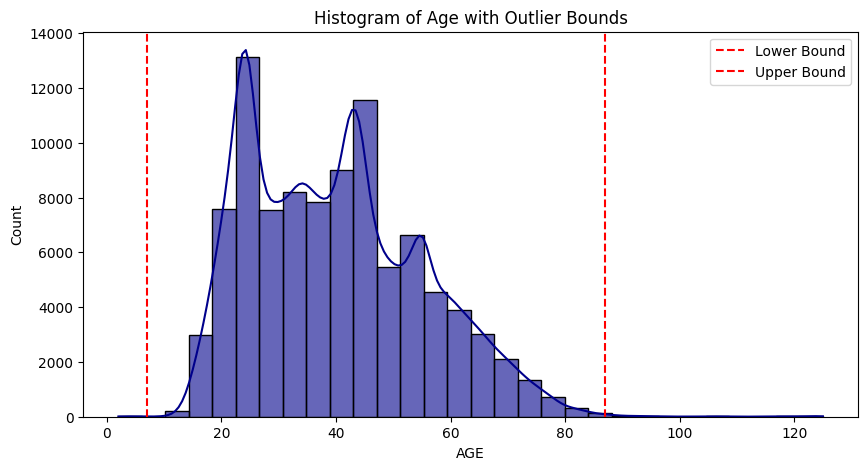

In [75]:
# Plot Age distribution

plt.figure(figsize=(10,5))
sns.histplot(users['AGE'], bins=30, kde=True, color='darkblue', alpha=0.6)
plt.axvline(lower_bound, color='red', linestyle='dashed', label="Lower Bound")
plt.axvline(upper_bound, color='red', linestyle='dashed', label="Upper Bound")

plt.title("Histogram of Age with Outlier Bounds")
plt.legend()
plt.show()


In [45]:
unique_counts = users.nunique()
print(unique_counts)

ID              100000
CREATED_DATE      2783
BIRTH_DATE       21819
STATE               52
LANGUAGE             2
GENDER              11
AGE                121
dtype: int64


In [46]:
print(users['LANGUAGE'].value_counts())
# "Es-419" is a locale code that refers to the Spanish language used in the Caribbean and Latin America
print(users['GENDER'].value_counts())

LANGUAGE
en        63403
es-419     6089
Name: count, dtype: int64
GENDER
female                    64240
male                      25829
transgender                1772
prefer_not_to_say          1350
non_binary                  473
unknown                     196
not_listed                  180
Non-Binary                   34
not_specified                28
My gender isn't listed        5
Prefer not to say             1
Name: count, dtype: int64


In [82]:
# Question 1
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

query = """
SELECT p.brand, count(distinct t.receipt_id) as receipt_count FROM
transactions t
INNER JOIN users u
  on t.USER_ID=u.ID
LEFT JOIN products p
  on t.barcode = p.barcode
WHERE u.AGE >= 21 AND p.brand != 'None'
GROUP BY p.brand
ORDER BY receipt_count desc
LIMIT 5;
"""

Q1 = pysqldf(query)
display(Q1)

# A: Nerds candy, Dove, Sour Patch Kids, Hershey's, Coca-Cola

,BRAND,receipt_count
0,NERDS CANDY,14
1,DOVE,14
2,SOUR PATCH KIDS,13
3,HERSHEY'S,13
4,COCA-COLA,13


In [95]:
# Question 2
query = """
WITH user_transactions AS (
    SELECT t.*, u.CREATED_DATE
    FROM transactions t
    INNER JOIN users u
    ON t.USER_ID = u.ID
    WHERE (JULIANDAY('now') - JULIANDAY(u.CREATED_DATE))
    -- WHERE DATEDIFF(CURRENT_DATE(), u.CREATED_DATE) / 30 >= 6
),
prod_transactions AS (
    SELECT p.BRAND, SUM(ut.FINAL_SALE) AS TOTAL_SALES
    FROM user_transactions ut
    LEFT JOIN products p
    ON ut.BARCODE = p.BARCODE
    WHERE p.BRAND IS NOT NULL AND p.BRAND <> 'BRAND NOT KNOWN'
    GROUP BY p.BRAND
)
SELECT BRAND, TOTAL_SALES
FROM prod_transactions
ORDER BY TOTAL_SALES DESC
LIMIT 5;
"""

Q2 = pysqldf(query)
display(Q2)

,BRAND,TOTAL_SALES
0,COCA-COLA,2592.10
1,ANNIE'S HOMEGROWN GROCERY,2383.92
2,DOVE,2327.47
3,BAREFOOT,2284.59
4,ORIBE,2085.93


In [97]:
# Question 2 without outliers in age
query = """
WITH user_transactions AS (
    SELECT t.*, u.CREATED_DATE
    FROM transactions t
    INNER JOIN users u
    ON t.USER_ID = u.ID
    WHERE (JULIANDAY('now') - JULIANDAY(u.CREATED_DATE)) AND (u.AGE BETWEEN 7 AND 87)
    -- WHERE DATEDIFF(CURRENT_DATE(), u.CREATED_DATE) / 30 >= 6
),
prod_transactions AS (
    SELECT p.BRAND, SUM(ut.FINAL_SALE) AS TOTAL_SALES
    FROM user_transactions ut
    LEFT JOIN products p
    ON ut.BARCODE = p.BARCODE
    WHERE p.BRAND IS NOT NULL AND p.BRAND <> 'BRAND NOT KNOWN'
    GROUP BY p.BRAND
)
SELECT BRAND, TOTAL_SALES
FROM prod_transactions
ORDER BY TOTAL_SALES DESC
LIMIT 5;
"""

Q2 = pysqldf(query)
display(Q2)

# Coca-cola, Annie's Homegrown Grocery, Dove, Barefoot, Oribe. Top sales not affected by age outliers.

,BRAND,TOTAL_SALES
0,COCA-COLA,2592.10
1,ANNIE'S HOMEGROWN GROCERY,2383.92
2,DOVE,2327.47
3,BAREFOOT,2284.59
4,ORIBE,2085.93


Open ended: Which is the leading brand in the Dips & Salsa category?

In [98]:
# First determining which Category would contain 'Dips & Salsa'
query = """
SELECT CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4
FROM products
WHERE 'Dips & Salsa' IN (CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4)
LIMIT 10;
"""
Q3_0 = pysqldf(query)
display(Q3_0)

# It's Category 2.

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4
0,Snacks,Dips & Salsa,Hummus,None
1,Snacks,Dips & Salsa,Ranch Dip,None
2,Snacks,Dips & Salsa,Ranch Dip,None
3,Snacks,Dips & Salsa,Hummus,None
4,Snacks,Dips & Salsa,Ranch Dip,None
5,Snacks,Dips & Salsa,Dip Mixes,None
6,Snacks,Dips & Salsa,Salsa,None
7,Snacks,Dips & Salsa,Salsa,None
8,Snacks,Dips & Salsa,Hummus,None
9,Snacks,Dips & Salsa,Dip Mixes,None


In [100]:
# I will rank the leading brand by SALES. Though there are only 89 days worth of Purchases in the Transactions table.
query = """
WITH prod_transactions AS (
    SELECT p.BRAND, SUM(t.FINAL_SALE) AS TOTAL_SALES
    FROM transactions t
    LEFT JOIN products p
    ON t.BARCODE = p.BARCODE
    WHERE p.BRAND IS NOT NULL AND p.BRAND <> 'BRAND NOT KNOWN'
    AND p.CATEGORY_2 = 'Dips & Salsa'
    GROUP BY p.BRAND
)
SELECT BRAND, TOTAL_SALES
FROM prod_transactions
ORDER BY TOTAL_SALES DESC
LIMIT 1;
"""
Q3_1 = pysqldf(query)
display(Q3_1)

# It's Tostitos, with a total sales of $103,354.84 (for all time)

,BRAND,TOTAL_SALES
0,TOSTITOS,103354.84
1,FRITOS,82566.81
2,FRESH CRAVINGS,82514.05
3,OLD EL PASO,82475.08
4,GOOD FOODS,61975.20
